In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import GaussianHMM

import yfinance as yf
import math

import matplotlib.pyplot as plt

## N-BEATS model class

In [2]:
class NbeatsBlock (nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers) -> None:
        '''
            input_size: int, size of the input
            hidden_size: int, size of the hidden layers
            output_size: int, size of the output
            n_layers: int, number of layers
        '''
        super().__init__()

        self.fc = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(input_size if i == 0 else hidden_size, hidden_size if i < n_layers else output_size),
                nn.ReLU()
            ) for i in range(n_layers + 1)]
        )

    def forward(self, x):
        return self.fc(x)

In [3]:
class Nbeats(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=4, n_stacks=3) -> None:
        '''
            input_size: int, size of the input
            hidden_size: int, size of the hidden layers
            output_size: int, size of the output
            n_layers: int, number of layers
            n_stacks: int, number of stacks
        '''
        super().__init__()

        self.stacks = nn.ModuleList(
            [NbeatsBlock(input_size, hidden_size, output_size, n_layers) for _ in range(n_stacks)]
        )

    def forward(self, x):
        forcast = sum(stack(x) for stack in self.stacks)
        return forcast

## TimesNet model class

In [4]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            # THE FIX IS HERE: We need to provide x_mark to use temporal_embedding
            x = self.value_embedding(
                x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)

class Inception_Block_V1(nn.Module):
    def __init__(self, in_channels, out_channels, num_kernels=6, init_weight=True):
        super(Inception_Block_V1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_kernels = num_kernels
        kernels = []
        for i in range(self.num_kernels):
            kernels.append(nn.Conv2d(in_channels, out_channels, kernel_size=2 * i + 1, padding=i))
        self.kernels = nn.ModuleList(kernels)
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        res_list = []
        for i in range(self.num_kernels):
            res_list.append(self.kernels[i](x))
        res = torch.cat(res_list, dim=1)
        return res

def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]


class TimesBlock(nn.Module):
    def __init__(self, configs):
        super(TimesBlock, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.k = configs.top_k
        # parameter-efficient design
        self.conv = nn.Sequential(
            Inception_Block_V1(configs.d_model, configs.d_ff,
                               num_kernels=configs.num_kernels),
            nn.GELU(),
            Inception_Block_V1(configs.d_ff * configs.num_kernels, configs.d_model,
                               num_kernels=configs.num_kernels)
        )

    def forward(self, x):
        B, T, N = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)

        res = []
        for i in range(self.k):
            period = period_list[i]
            # padding
            if (self.seq_len + self.pred_len) % period != 0:
                length = (
                                 ((self.seq_len + self.pred_len) // period) + 1) * period
                padding = torch.zeros([x.shape[0], (length - (self.seq_len + self.pred_len)), x.shape[2]]).to(x.device)
                out = torch.cat([x, padding], dim=1)
            else:
                length = (self.seq_len + self.pred_len)
                out = x
            # reshape
            out = out.reshape(B, length // period, period,
                              N).permute(0, 3, 1, 2).contiguous()
            # 2D conv: from 1d Variation to 2d Variation
            out = self.conv(out)
            # reshape back
            out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
            res.append(out[:, :(self.seq_len + self.pred_len), :])
        res = torch.stack(res, dim=-1)
        # adaptive aggregation
        period_weight = F.softmax(period_weight, dim=1)
        period_weight = period_weight.unsqueeze(
            1).unsqueeze(1).repeat(1, T, N, 1)
        res = torch.sum(res * period_weight, -1)
        # residual connection
        res = res + x
        return res


class TimesNetModel(nn.Module):
    """
    Paper link: https://openreview.net/pdf?id=ju_Uqw384Oq
    """

    def __init__(self, configs):
        super(TimesNetModel, self).__init__()
        self.configs = configs
        self.task_name = configs.task_name
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len
        self.model = nn.ModuleList([TimesBlock(configs)
                                    for _ in range(configs.e_layers)])
        self.enc_embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq,
                                           configs.dropout)
        self.layer = configs.e_layers
        self.layer_norm = nn.LayerNorm(configs.d_model)
        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            self.predict_linear = nn.Linear(
                self.seq_len, self.pred_len + self.seq_len)
            self.projection = nn.Linear(
                configs.d_model, configs.c_out, bias=True)
        # ... (rest of the Model class)
    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        # Normalization from Non-stationary Transformer
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc.sub(means)
        stdev = torch.sqrt(
            torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc = x_enc.div(stdev)

        # embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc)  # [B,T,C]
        enc_out = self.predict_linear(enc_out.permute(0, 2, 1)).permute(
            0, 2, 1)  # align temporal dimension
        # TimesNet
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))
        # project back
        dec_out = self.projection(enc_out)

        # De-Normalization from Non-stationary Transformer
        dec_out = dec_out.mul(stdev)
        dec_out = dec_out.add(means)
        return dec_out

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]
        # ... (rest of the forward method)
        return None

In [5]:
def create_time_features(df, time_col='Date', freq='d'):
    """
    Creates time series features from a datetime index.
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df['month'] = df[time_col].dt.month
    df['day'] = df[time_col].dt.day
    df['weekday'] = df[time_col].dt.dayofweek
    # Add more features if needed, like 'weekofyear'

    # The TimeFeatureEmbedding expects these features in a specific order based on `freq`
    if freq == 'd': # Daily
        feature_cols = ['month', 'day', 'weekday']
    else: # Add more logic for other frequencies if needed
        raise NotImplementedError(f"Frequency '{freq}' not implemented.")

    return df[feature_cols].values

# This function creates input/output sequences
def create_sequences(input_data, time_features, seq_len, pred_len):
    X, y, X_mark = [], [], []
    for i in range(len(input_data) - seq_len - pred_len + 1):
        X.append(input_data[i:(i + seq_len)])
        y.append(input_data[i + seq_len:i + seq_len + pred_len])
        X_mark.append(time_features[i:(i + seq_len)])
    return np.array(X), np.array(y), np.array(X_mark)

# data loading and manipulation

In [ ]:
# Load Data
ticker = 'BTC-USD'
btc_data = yf.download(ticker, start='2014-01-01', end='2024-01-01')
btc_data.reset_index(inplace=True) # Move 'Date' from index to a column

# Feature Engineering
# 'Close' price - forecasting
price_data = btc_data[['Close']].values
# Create time features
time_features = create_time_features(btc_data, time_col='Date', freq='d')

# Scaling
scaler = StandardScaler()
# Fit only on the training data to avoid data leakage
train_size = int(len(price_data) * 0.8)
scaler.fit(price_data[:train_size])
scaled_data = scaler.transform(price_data)

# Create Sequences
configs = type("Configs", (), {})() # Create a mock configs class
configs.seq_len = 14 # Use 30 days of history
configs.pred_len = 1 # Predict 1 day ahead
configs.enc_in = 1 # We are using 1 feature (Close price)
configs.c_out = 1

X, y, X_mark = create_sequences(scaled_data, time_features, configs.seq_len, configs.pred_len)


In [ ]:
# Split Data
X_train, X_test, y_train, y_test, X_mark_train, X_mark_test = train_test_split(
    X, y, X_mark, test_size=0.2, shuffle=False # Time series data should not be shuffled
)

# to Tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_mark_train = torch.tensor(X_mark_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_mark_test = torch.tensor(X_mark_test, dtype=torch.float32)

In [ ]:
#  3. TimesNet-Model Training
# Hyperparameters for the Model
configs.task_name = 'long_term_forecast'
configs.label_len = 0
configs.e_layers = 1
configs.d_model = 32
configs.d_ff = 64
configs.num_kernels = 3
configs.embed = 'timeF' # Use TimeFeatureEmbedding
configs.freq = 'd'
configs.dropout = 0.05
configs.top_k = 3

# 3.1 N-Beats Model Hyperparameters
nbeats_configs = {
    'input_size': configs.seq_len,
    'hidden_size': 64,
    'output_size': configs.pred_len,
    'n_layers': 4,
    'n_stacks': 3
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# train N-Beats model
nbeats_model = Nbeats(**nbeats_configs).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(nbeats_model.parameters(), lr=0.001)

X_train_nbeats = X_train.reshape(X_train.shape[0], -1).to(device) # N-Beats expects [B, seq_len]
y_train_nbeats = y_train.reshape(y_train.shape[0], -1).to(device) # N-Beats expects [B, pred_len]

epochs = 1000
best_loss = float('inf')
best_nbeats_model_path = "models/best_nbeats_model.pth"

for epoch in range(epochs):
    nbeats_model.train()
    optimizer.zero_grad()
    output = nbeats_model(X_train_nbeats)
    loss = criterion(output, y_train_nbeats)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        nbeats_model.eval()
        X_test_nbeats = X_test.reshape(X_test.shape[0], -1).to(device)
        y_test_nbeats = y_test.reshape(y_test.shape[0], -1).to(device)
        test_output = nbeats_model(X_test_nbeats)
        test_loss = criterion(test_output, y_test_nbeats)
        if (epoch + 1) % 100 == 0:
            print(f" [{epoch+1}/{epochs}] Loss: {loss.item():.4f} | {test_loss.item():.4f}")

    # Save the best model
    if test_loss.item() < best_loss:
        best_loss = test_loss.item()
        torch.save(nbeats_model.state_dict(), best_nbeats_model_path)
        print(f"Best model saved with loss : {best_loss:.4f}")

Best model saved with loss : 1.0490
Best model saved with loss : 0.9641
Best model saved with loss : 0.8946
Best model saved with loss : 0.8285
Best model saved with loss : 0.7601
Best model saved with loss : 0.6882
Best model saved with loss : 0.6133
Best model saved with loss : 0.5324
Best model saved with loss : 0.4470
Best model saved with loss : 0.3606
Best model saved with loss : 0.2758
Best model saved with loss : 0.1951
Best model saved with loss : 0.1234
Best model saved with loss : 0.0665
Best model saved with loss : 0.0311
Best model saved with loss : 0.0237
Best model saved with loss : 0.0180
Best model saved with loss : 0.0153
Best model saved with loss : 0.0153
Best model saved with loss : 0.0142
 [100/1000] Loss: 0.2058 | 0.0138
Best model saved with loss : 0.0138
Best model saved with loss : 0.0131
Best model saved with loss : 0.0117
Best model saved with loss : 0.0108
Best model saved with loss : 0.0105
Best model saved with loss : 0.0105
Best model saved with loss : 0

In [ ]:
nbeats_model.load_state_dict(torch.load(best_nbeats_model_path))
nbeats_model.eval()

with torch.no_grad():
    nbeats_preds_train = nbeats_model(X_train_nbeats)
    y_train_squeezed = y_train_nbeats.squeeze(-1)
    residuals_train = y_train_squeezed - nbeats_preds_train

y_residuals_train = residuals_train.unsqueeze(-1).to(device) # [B, pred_len] -> [B, pred_len, 1]

timesnet_model = TimesNetModel(configs).to(device)
optimizer = optim.Adam(timesnet_model.parameters(), lr=0.001)

X_train_timesnet = X_train.to(device)
X_mark_train_timesnet = X_mark_train.to(device)

epochs = 1000
best_loss = float('inf')
best_timesnet_model_path = "models/best_timesnet_model.pth"
batch_size = 2690

for epoch in range(epochs):
    timesnet_model.train()
    epoch_loss = 0.0
    for i in range(0, len(X_train_timesnet), batch_size):
        batch_X = X_train_timesnet[i:i+batch_size]
        batch_y = y_train_nbeats[i:i+batch_size].to(device)
        batch_X_mark = X_mark_train_timesnet[i:i+batch_size].to(device)
        batch_y_residuals = y_residuals_train[i:i+batch_size].to(device)

        batch_dec_input = torch.zeros_like(batch_y_residuals).to(device)
        optimizer.zero_grad()

        outputs = timesnet_model(batch_X, batch_X_mark, batch_dec_input, batch_dec_input)
        loss = criterion(outputs, batch_y_residuals)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)

    with torch.no_grad():
        timesnet_model.eval()
        X_test_timesnet = X_test.to(device)
        X_mark_test_timesnet = X_mark_test.to(device)
        y_test_nbeats_device = y_test_nbeats.to(device)
        y_test_residuals = (y_test_nbeats_device - nbeats_model(X_test_nbeats)).unsqueeze(-1).to(device)

        test_dec_input = torch.zeros_like(y_test_residuals).to(device)
        test_outputs = timesnet_model(X_test_timesnet, X_mark_test_timesnet, test_dec_input, test_dec_input)
        test_loss = criterion(test_outputs, y_test_residuals)

    epoch_loss /= len(X_train_timesnet)
    if (epoch + 1) % 10 == 0:
        print(f"[{epoch+1}/{epochs}, Loss {loss.item():.4f} | {test_loss.item():.4f}")

    # Save the best model
    if test_loss.item() < best_loss:
        best_loss = test_loss.item()
        torch.save(timesnet_model.state_dict(), best_timesnet_model_path)

d:\Program Files\python311\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([2690, 2703, 1])) that is different to the input size (torch.Size([2690, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Program Files\python311\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([13, 2703, 1])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[10/200, Loss 3.5756 | 0.7572
[20/200, Loss 3.4616 | 0.6966
[30/200, Loss 3.3442 | 0.6376
[40/200, Loss 3.2241 | 0.5816
[50/200, Loss 3.1034 | 0.5305
[60/200, Loss 2.9842 | 0.4860
[70/200, Loss 2.8686 | 0.4502
[80/200, Loss 2.7587 | 0.4244
[90/200, Loss 2.6564 | 0.4099
[100/200, Loss 2.5632 | 0.4077
[110/200, Loss 2.4803 | 0.4181
[120/200, Loss 2.4087 | 0.4413
[130/200, Loss 2.3487 | 0.4767
[140/200, Loss 2.3006 | 0.5236
[150/200, Loss 2.2639 | 0.5805
[160/200, Loss 2.2380 | 0.6458
[170/200, Loss 2.2220 | 0.7176
[180/200, Loss 2.2145 | 0.7938
[190/200, Loss 2.2141 | 0.8723
[200/200, Loss 2.2196 | 0.9510


In [ ]:
# inference
class ResidualEnsemble(nn.Module):
    def __init__(self, nbeats_configs, nbeats_model_path, timesnet_configs, timesnet_model_path):
        super(ResidualEnsemble, self).__init__()
        self.nbeats_model = Nbeats(**nbeats_configs)
        self.timesnet_model = TimesNetModel(timesnet_configs)

        self.nbeats_model.load_state_dict(torch.load(nbeats_model_path))
        self.timesnet_model.load_state_dict(torch.load(timesnet_model_path))

        self.nbeats_model.eval()
        self.timesnet_model.eval()

    def forward(self, x_enc, x_mark_enc):
        with torch.inference_mode():
            # nbeats prediction
            nbeats_input = x_enc.view(x_enc.size(0), -1) # [B, seq_len]
            nbeats_out_flat = self.nbeats_model(nbeats_input) # [B, pred_len]
            nbeats_out = nbeats_out_flat.unsqueeze(-1) # [B, pred_len, 1]
            
            # timesnet prediction on residuals
            dec_input = torch.zeros_like(nbeats_out).to(x_enc.device)
            residual_out = self.timesnet_model(x_enc, x_mark_enc, dec_input, dec_input) # [B, pred_len, 1]

            # Final prediction
            final_out = nbeats_out + residual_out
            return final_out


In [ ]:
class RegimeDetector:
    def __init__(self, n_states=3):
        self.n_states = n_states
        self.model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000)
        self.scaler = StandardScaler()
        self.fitted = False

    def fit(self, df):
        df['logreturns'] = np.log(df['Close'] / df['Close'].shift(1))
        df['volume'] = df['logreturns'].rolling(window=14).std().fillna(method='bfill')
        X = df[['logreturns', 'volume', 'residuals_train']].fillna(0).values

        X_scaled = self.scaler.fit_transform(X)
        self.model.fit(X_scaled)
        self.fitted = True

    def detect(self, new_obs):
        if not self.fitted:
            raise ValueError("RegimeDetector must be fitted first.")
        
        new_obs_scaled = self.scaler.transform(new_obs.reshape(1,-1))
        # Posterior over states
        logprob, posteriors = self.model.score_samples(new_obs_scaled)
        current_state = np.argmax(posteriors)
        return current_state, posteriors

In [ ]:
detector = RegimeDetector(n_states=3)
detector.fit(btc_data.assign(residual=np.zeros(len(btc_data))))  # fitting on the initial history (residuals will be updated later)

ensemble = ResidualEnsemble(nbeats_configs, "models/best_nbeats_model.pth", configs, "models/best_timesnet_model.pth").to(device)

preds, states = [], []
for t in range(len(X)):
    x_enc = torch.tensor(X[t], dtype=torch.float32).unsqueeze(0).to(device)   # [1, seq_len, 1]
    x_mark_enc = torch.tensor(X_mark[t], dtype=torch.float32).unsqueeze(0).to(device)

    y_pred = ensemble(x_enc, x_mark_enc).cpu().detach().numpy().flatten()
    preds.append(y_pred)

    # update residual
    y_true = y[t].flatten()
    residual = y_true - y_pred
    
    # regime detection
    new_obs = np.array([y_true - X[t,-1,0], np.std(X[t,:,0]), residual.mean()])  # returns [vol, residual]
    state, probs = detector.detect(new_obs)
    states.append(state)

    # Adaptation policy
    if state == 0:  
        # e.g., bull regime: trust NBEATS more (skip residual correction)
        y_pred_final = y_pred  
    elif state == 1:  
        # bear regime: trust residual correction more (keep ensemble)
        y_pred_final = y_pred  
    else:  
        # high volatility regime: fallback to naive prediction (last price)
        y_pred_final = X[t,-1,0]  

    preds[-1] = y_pred_final


In [ ]:
ensemble = ResidualEnsemble(nbeats_configs, best_nbeats_model_path, 
    configs, best_timesnet_model_path).to(device)
ensemble.eval()

with torch.inference_mode():
    ensemble_preds_test = ensemble(X_test.to(device), X_mark_test.to(device))

pred_scaled = ensemble_preds_test.squeeze(-1).cpu().numpy()
actual_scaled = y_test.squeeze(-1).cpu().numpy()

preds = scaler.inverse_transform(pred_scaled)
actuals = scaler.inverse_transform(actual_scaled)

test_mse = np.mean((preds - actuals) ** 2)

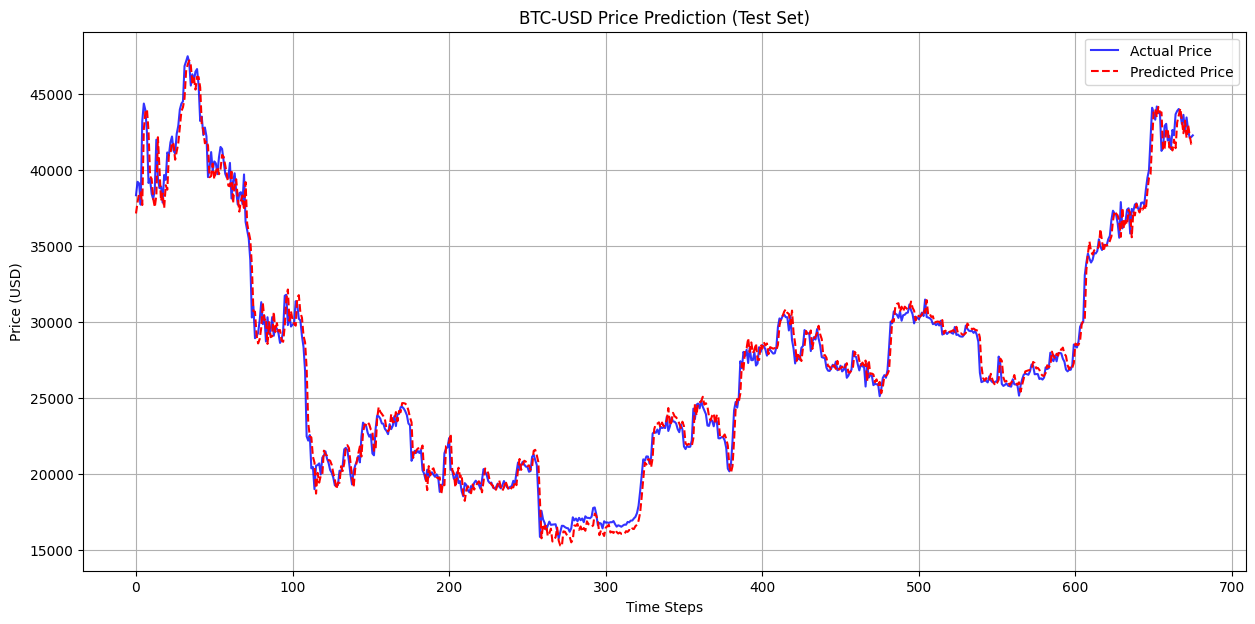

In [ ]:
# Plot the results
plt.figure(figsize=(15, 7))
plt.plot(actuals.flatten(), label='Actual Price', color='blue', alpha=0.7)
plt.plot(preds.flatten(), label='Predicted Price', color='red', linestyle='--')
plt.title('BTC-USD Price Prediction (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()